In [1]:
%matplotlib notebook
import random as rn
import numpy as np, numpy.random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from pyomo.environ import *
import time
import random 

In [2]:
def corrigir(a):
    for x in ['[', ']', ',']:
        a = a.replace(x, '')
    a = a.split(' ')
    lista= list(map(int, a))
    return lista

def leitura(arquivo):
    data = np.loadtxt(arquivo, delimiter='\t',dtype=str)
    # Lista com os valores da importância de cada item r em relação a cada objetivo j
    v = []
    for i in range(int(data[0])):
        mudança1 = corrigir(data[3+i])
        v.append(mudança1)
    w = corrigir(data[3+int(data[0])])
    
    return int(data[0]), int(data[1]), int(data[2]), v, w

In [3]:
def modelo_metodoPonderacoes(W1, W2, W3, p, N, v, w, W):
    p = ConcreteModel()
    
    # Inicializa o problema p que será resolvido com o solver
    p.Itens = range(N)
    
    # x é uma lista de variáveis
    p.x = Var(p.Itens, within = Binary)
    
    # soma wi*xi <= W
    p.restricao = Constraint(expr = sum( w[i]*p.x[i] for i in p.Itens ) <= W )
    
    # Função
    p.f1 = sum( v[0][i]*p.x[i] for i in p.Itens )
    
    p.f2 = sum( v[1][i]*p.x[i] for i in p.Itens )
    
    p.f3 = sum( v[2][i]*p.x[i] for i in p.Itens )

    # declaro a função-objetivo
    p.obj = Objective(expr= W1*p.f1 + W2*p.f2 + W3*p.f3, sense = maximize)

    # Resolve
    solver = SolverFactory('glpk')
    solver.solve(p, tee=False)
    f1 = sum( v[0][i]*p.x[i] for i in p.Itens )
    f2 = sum( v[1][i]*p.x[i] for i in p.Itens )
    f3 = sum( v[2][i]*p.x[i] for i in p.Itens )

    return [f1(), f2(), f3()]

In [16]:
def metodoPonderacoes(p, N, v, w, W):
    inicio = time.time()
    discretizacoes = np.arange(0.0 ,1.1, 0.1)
    pontosf = []
    for W1 in discretizacoes: 
        for W2 in discretizacoes: 
            W3 = 1 - (W1 + W2)
            if W1 >= 0 and W2 >= 0 and W3 >= 0:
                ponto = modelo_metodoPonderacoes(W1, W2, W3, p, N, v, w, W)
                pontosf.append(ponto)         
    fim = time.time()
    return pontosf, fim - inicio

In [17]:
p, N, W, v, w = leitura('KP_p-3_n-10_ins-1.dat')
p, N, W, v, w

(3,
 10,
 2137,
 [[566, 611, 506, 180, 817, 184, 585, 423, 26, 317],
  [62, 84, 977, 979, 874, 54, 269, 93, 881, 563],
  [664, 982, 962, 140, 224, 215, 12, 869, 332, 537]],
 [557, 898, 148, 63, 78, 964, 246, 662, 386, 272])

In [18]:
pontosf, tempo1 = metodoPonderacoes(p, N, v, w, W)
print('\nMetodo das Ponderação: ')
print(f'Pontos: {len(pontosf)}')
print("Tempo de execução: ", tempo1)


Metodo das Ponderação: 
Pontos: 66
Tempo de execução:  3.83052921295166


In [19]:
fig2 = plt.figure()         
ax2 = Axes3D(fig2)
for i in range(len(pontosf)):
    ax2.scatter(pontosf[i][0], pontosf[i][1], pontosf[i][2], c='black') 
    plt.title("Espaço de Decisão")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')    
plt.show()

<IPython.core.display.Javascript object>

In [20]:
aaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaa' is not defined

# NSGA-II

In [51]:
def inicializaPopulacao(VAR, TP):
    populacao = np.random.randint(2, size=(TP, VAR))  # matriz TP linhas VAR colunas
    return populacao


# Kursawe function - https://en.wikipedia.org/wiki/Test_functions_for_optimization
def avalia_populacao(populacao, p, VAR, v, W, w):
    TPtotal = populacao.shape[0]  # qtde de linhas da populacao
    funcoes = np.zeros((TPtotal, p)) # 3 funções-objetivo
    for ind,x in enumerate(populacao):        
        obj1 = 0
        for j in range(VAR):
            obj1 += v[0][j]*x[j] 

        obj2 = 0
        for j in range(VAR):
            obj2 += v[1][j]*x[j] 
        
        obj3 = 0
        for j in range(VAR):
            obj3 += v[2][j]*x[j]
    
        funcoes[ind,0] = obj1
        funcoes[ind,1] = obj2
        funcoes[ind,2] = obj3
    
    # Penalizar toda população
    #print(W,  sum(w[r]*populacao[:, r] for r in range(VAR)))
    # Os indivíduos que apresentarem valores acima de W apresentam resultados positivos e W abaixo ou igual são negativos
    penalidade = 100*(W - sum(w[r]*populacao[:, r] for r in range(VAR)))
    #print(penalidade)
    # Valores Positivos são mantidos e valores negativos são transformados em zero  
    penalidade = np.where(penalidade < 0, penalidade, 0)
    #print(penalidade)
    # é criado uma nova matriz que repete os valores da penalidade
    # Essa matriz será utilizada para somar com os valores de fitness da população avaliada
    penalidade = np.repeat(penalidade[:, np.newaxis], funcoes.shape[1], axis=1)
    #print(penalidade)
    #print(funcoes + penalidade)
    
    return funcoes + penalidade

# 2 pais são aleatoriamente selecionados da populacao
# gerando 2 filhos através de crossover aritmético
def crossover(populacao, TX_crossover, TP, VAR):
    filhos = np.zeros((TX_crossover, VAR), dtype=int)
    for i in range(int(TX_crossover/2)):
        r1 = np.random.randint(0, TP)   # intervalo [0, TP)
        r2 = np.random.randint(0, TP)
        while r1 == r2:
            r2 = np.random.randint(0, TP)
        ponto = random.randint(1, VAR-1)
        filhos[2*i] = list(populacao[r1][:ponto]) + list(populacao[r2][ponto:])
        filhos[2*i+1] = list(populacao[r2][:ponto]) + list(populacao[r1][ponto:])     

    return filhos 


# 1 individuo da populacao é selecionado aleatoriamente
# gerando um individuo através de uma perturbação em uma das variáveis
def busca_local(populacao, TX_busca_local, TP, VAR):
    filhos = np.zeros((TX_busca_local, VAR))
    for i in range(TX_busca_local):
        ind = np.random.randint(0, TP)
        individuo = populacao[ind, :]
        
        v = np.random.randint(0, VAR)
        individuo[v] = 1 - individuo[v]
        filhos[i,:] = individuo
    return filhos


# gerando 2 filhos através de troca de coordenadas
def mutacao(populacao, TX_mutacao, TP, VAR):
    filhos = np.zeros((TX_mutacao, VAR), dtype=int)
    for i in range(int(TX_mutacao/2)):
        r1 = np.random.randint(0, TP)
        r2 = np.random.randint(0, TP)
        while r1 == r2:
            r2 = np.random.randint(0, TP)
        var_troca = np.random.randint(0, VAR)
        filhos[2*i] = populacao[r1]
        filhos[2*i, var_troca] = populacao[r2, var_troca]
        filhos[2*i+1] = populacao[r2]
        filhos[2*i+1, var_troca] = populacao[r1, var_troca]

    return filhos


def crowding(fitness):
    tam_pop = len(fitness[:, 0])   # quantidade de pontos
    funcoes = len(fitness[0, :])   # quantidade de funções-objetivo               
    matriz_crowding = np.zeros((tam_pop, funcoes))  
    # fitness.ptp(0) array com máximos de cada coluna
    fitness_normalizado = (fitness - fitness.min(0))/fitness.ptp(0)
    
    # para cada função-objetivo
    for i in range(funcoes):
        crowding_resultado = np.zeros(tam_pop)
        
        # pontos extremos tem o maior resultado de crowding
        crowding_resultado[0] = 1             
        crowding_resultado[tam_pop - 1] = 1    
        
        fitness_normalizado_ordenado = np.sort(fitness_normalizado[:,i])
        indices_fitness_normalizado = np.argsort(fitness_normalizado[:,i])
        
        # crowding distance: solução i, crowding = fitness[i+1] - fitness[i-1]
        crowding_resultado[1:tam_pop-1] = (fitness_normalizado_ordenado[2:tam_pop] - fitness_normalizado_ordenado[0:tam_pop-2])
        reordenar = np.argsort(indices_fitness_normalizado)
        matriz_crowding[:, i] = crowding_resultado[reordenar]
    
    crowding_distance = np.sum(matriz_crowding, axis=1) 

    return crowding_distance   


def seleciona_com_crowding(fitness, qtde):
    # atribui índices às soluções sob análise: da última fronteira
    indices = np.arange(fitness.shape[0])
    
    # soluções que serão selecionadas
    solucoes_selecionadas = np.zeros(qtde)
    
    # calcula o crowding distance
    crowding_distance = crowding(fitness)
    
    crowding_distance_ordenado = -np.sort(-crowding_distance)
    indices_ordenado = np.argsort(-crowding_distance)
    
    # para a quantidade que deve ser selecionada
    for i in range(qtde):
        solucoes_selecionadas[i] = indices_ordenado[i]
        
    solucoes_selecionadas = np.array(solucoes_selecionadas, dtype=int)

    return solucoes_selecionadas


# encontrar o índice das soluções não-dominadas 
def encontra_fronteira(fitness, indices, violacao):
    tam_pop = fitness.shape[0]
    fronteira_nd = np.ones(tam_pop, dtype=bool)    # todos True=1 inicialmente
    for i in range(tam_pop):
        for j in range(tam_pop):
            # Minimização!
            # j não é pior que i em nenhum dos objetivos e é melhor em pelo menos um
            if all(fitness[j] >= fitness[i]) and any(fitness[j] > fitness[i]):
                # i não faz parte da fronteira de Pareto porque j domina i
                fronteira_nd[i] = 0               # muda para False=0
                break
                
    return indices[fronteira_nd] 

def selecao(populacao, fitness, TP, violacao):
    
    # índices ainda não selecionados
    indices_nao_selec = np.arange(populacao.shape[0])  
    
    # todos os índices
    indices = np.arange(populacao.shape[0])  
    
    # fronteira não-dominada
    fronteira_nd_indices = []
    
    # enquanto a fronteira for menor que TP
    while len(fronteira_nd_indices) < TP:
        # encontra a nova fronteira, dentre os índices não selecionados
        nova_fronteira = encontra_fronteira(fitness[indices_nao_selec, :], indices_nao_selec, violacao)
        
        # total de soluções não-dominadas
        total_nd = len(fronteira_nd_indices) + len(nova_fronteira)

        # a última fronteira não coube toda
        if total_nd > TP:
            # quantidade que ainda pode ser inserida
            qtde = TP - len(fronteira_nd_indices)
            solucoes_selecionadas = seleciona_com_crowding(fitness[nova_fronteira], qtde)
            nova_fronteira = nova_fronteira[solucoes_selecionadas]
        
        fronteira_nd_indices = np.hstack((fronteira_nd_indices, nova_fronteira))
        restantes = set(indices) - set(fronteira_nd_indices)
        indices_nao_selec = np.array(list(restantes))
        
    populacao_selecionada = populacao[fronteira_nd_indices.astype(int)]

    return populacao_selecionada


def graficos2D3D(fitness, populacao):
    fig3 = plt.figure()         
    ax3 = Axes3D(fig3)                        
    ax3.scatter(fitness[:, 0],fitness[:, 1], fitness[:, 2]) 
    plt.title("Espaço dos objetivos")
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('z')
    plt.show()
    

def main():
    inicio = time.time()
    
    # Parameters
    TP = 150                  # Tamanho da população
    G = 150                  # Número de Gerações
       
    p, VAR, W, v, w = leitura('KP_p-3_n-10_ins-1.dat')
    
    TX_crossover = 30        
    TX_mutacao = 30          
    TX_busca_local = 20      
    passo_busca = 0.1             
    
    # Inicializa a População
    populacao = inicializaPopulacao(VAR, TP)
    fitness = avalia_populacao(populacao, p, VAR, v, W, w)   
    graficos2D3D(fitness, populacao)
    
    # NSGA-II main loop
    for i in range(G):
        filhos_crossover = crossover(populacao, TX_crossover, TP, VAR)
        filhos_mutacao = mutacao(populacao, TX_mutacao, TP, VAR)
        filhos_busca_local = busca_local(populacao, TX_busca_local, TP, VAR)
        # juntamos as populações de filhos Q (crossover, mutacao, busca local) à população P
        # formando uma população mista
        populacao = np.append(populacao, filhos_crossover, axis=0)
        populacao = np.append(populacao, filhos_mutacao, axis=0)
        populacao = np.append(populacao, filhos_busca_local, axis=0)
        
        fitness = avalia_populacao(populacao, p, VAR, v, W, w)
        populacao = selecao(populacao, fitness, TP, violacao)
    
    # Fronteira não-dominada
    fitness = avalia_populacao(populacao, p, VAR, v, W, w)
    indices = np.arange(populacao.shape[0]).astype(int)
    indices_fronteira_nd = encontra_fronteira(fitness, indices, violacao)
    populacao_nd = populacao[indices_fronteira_nd, :]
    qtde_nd = len(populacao_nd)
    fitness_nd = fitness[indices_fronteira_nd]
    graficos2D3D(fitness_nd, populacao_nd)

<IPython.core.display.Javascript object>


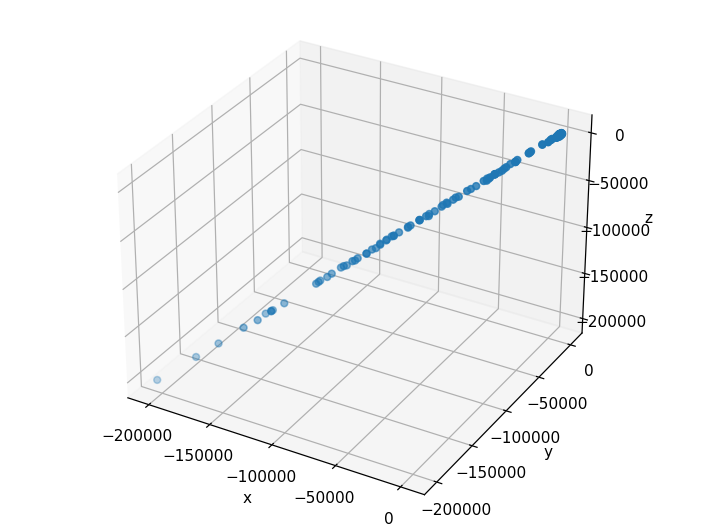

<IPython.core.display.Javascript object>


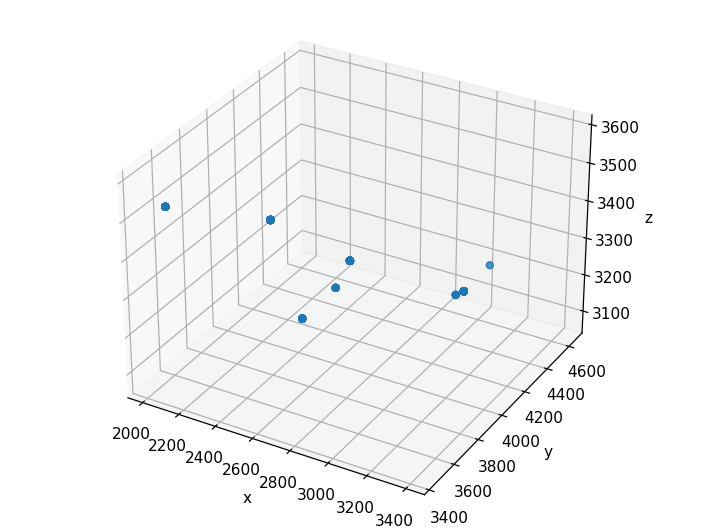

In [52]:
main()

In [ ]:
penalidade = 1000*(W - sum(w[r]*populacao[:, r] for r in range(n)))
penalidade = np.where(penalidade < 0, penalidade, 0)    
penalidade = np.repeat(penalidade[:, np.newaxis], funcoes.shape[1], axis=1)

In [ ]:
# encontrar o índice das soluções não-dominadas 
def encontra_fronteira(fitness, violacao, indices):
    tam_pop = fitness.shape[0]
    fronteira_nd = np.ones(tam_pop, dtype=bool)    # todos True=1 inicialmente
    for i in range(tam_pop):
        for j in range(tam_pop):
            if violacao[j] >= 0 and violacao[i] >= 0 and violacao[j] < violacao[i]:
                fronteira_nd[i] = 0
            elif violacao[j] == 0 and violacao[i] >= 0:
                fronteira_nd[i] = 0
            # Minimização!
            # j não é pior que i em nenhum dos objetivos e é melhor em pelo menos um
            elif violacao[j] == 0 and violacao[i] == 0 and all(fitness[j] <= fitness[i]) and any(fitness[j] < fitness[i]):
                # i não faz parte da fronteira de Pareto porque j domina i
                fronteira_nd[i] = 0               # muda para False=0
                break

    return indices[fronteira_nd]

In [5]:
s1 = [20, 30, 40, 50, 60]
violacao = []
for idx , i in enumerate(s1):
    violacao.append([i, i, i])

In [44]:
[2142, 1799, 1642] >= [3028, 2263, 3083]

False

In [ ]:
populacao = np.random.randint(2, size=(TP, VAR))